In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras import callbacks
import keras.backend as K

Using TensorFlow backend.


In [2]:
# LOAD DATA
df_train = pd.read_csv('trainold.csv', index_col=0)
y_train = df_train.pop('target')
len_train = len(df_train)
df_test = pd.read_csv('test.csv', index_col=0)
df_all = pd.concat((df_train, df_test), sort=False)
prev_cols = df_all.columns

In [3]:
# PREPROCESS
scaler = StandardScaler()
df_all[prev_cols] = scaler.fit_transform(df_all[prev_cols])
df_train = df_all[0:len_train]
df_test = df_all[len_train:]

In [4]:
# CROSS VALIDATION
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

In [5]:
# LOGGER
class Logger(callbacks.Callback):
    def __init__(self, out_path='./', patience=10, lr_patience=3, out_fn='', log_fn=''):
        self.auc = 0
        self.path = out_path
        self.fn = out_fn
        self.patience = patience
        self.lr_patience = lr_patience
        self.no_improve = 0
        self.no_improve_lr = 0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        cv_pred = self.model.predict(self.validation_data[0], batch_size=1024)
        cv_true = self.validation_data[1]
        auc_val = roc_auc_score(cv_true, cv_pred)
        if self.auc < auc_val:
            self.no_improve = 0
            self.no_improve_lr = 0
            print("Epoch %s - best AUC: %s" % (epoch, round(auc_val, 4)))
            self.auc = auc_val
            self.model.save(self.path + self.fn, overwrite=True)
        else:
            self.no_improve += 1
            self.no_improve_lr += 1
            print("Epoch %s - current AUC: %s" % (epoch, round(auc_val, 4)))
            if self.no_improve >= self.patience:
                self.model.stop_training = True
            if self.no_improve_lr >= self.lr_patience:
                lr = float(K.get_value(self.model.optimizer.lr))
                K.set_value(self.model.optimizer.lr, 0.75*lr)
                print("Setting lr to {}".format(0.75*lr))
                self.no_improve_lr = 0

        return

In [6]:
# MODEL DEF
def _Model():
    inp = Input(shape=(200, 1))
    d1 = Dense(16, activation='relu')(inp)
    fl = Flatten()(d1)
    preds = Dense(1, activation='sigmoid')(fl)
    model = Model(inputs=inp, outputs=preds)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
#print(hist.history)
from keras.callbacks import History 
history = History()

In [8]:
#RUN
preds = []
c = 0
oof_preds = np.zeros((len(df_train), 1))
for train, valid in cv.split(df_train, y_train):
    print("VAL %s" % c)
    X_train = np.reshape(df_train.iloc[train].values, (-1, 200, 1))
    y_train_ = y_train.iloc[train].values
    X_valid = np.reshape(df_train.iloc[valid].values, (-1, 200, 1))
    y_valid = y_train.iloc[valid].values
    model = _Model()
    logger = Logger(patience=10, out_path='./', out_fn='cv_{}.h5'.format(c))
    history = model.fit(X_train, y_train_, validation_data=(X_valid, y_valid), epochs=100, verbose=2, batch_size=256,
              callbacks=[logger])
    model.load_weights('cv_{}.h5'.format(c))
    X_test = np.reshape(df_test.values, (200000, 200, 1))
    curr_preds = model.predict(X_test, batch_size=2048)
    oof_preds[valid] = model.predict(X_valid)
    preds.append(curr_preds)
    c += 1
auc = roc_auc_score(y_train, oof_preds)
print("CV_AUC: {}".format(auc))

VAL 0
Train on 159999 samples, validate on 40001 samples
Epoch 1/100
 - 7s - loss: 0.2567 - accuracy: 0.9073 - val_loss: 0.2337 - val_accuracy: 0.9147
Epoch 0 - best AUC: 0.8552
Epoch 2/100
 - 7s - loss: 0.2289 - accuracy: 0.9150 - val_loss: 0.2253 - val_accuracy: 0.9180
Epoch 1 - best AUC: 0.867
Epoch 3/100
 - 6s - loss: 0.2193 - accuracy: 0.9182 - val_loss: 0.2184 - val_accuracy: 0.9197
Epoch 2 - best AUC: 0.8765
Epoch 4/100
 - 6s - loss: 0.2134 - accuracy: 0.9201 - val_loss: 0.2161 - val_accuracy: 0.9211
Epoch 3 - best AUC: 0.88
Epoch 5/100
 - 7s - loss: 0.2105 - accuracy: 0.9210 - val_loss: 0.2154 - val_accuracy: 0.9208
Epoch 4 - best AUC: 0.8817
Epoch 6/100
 - 7s - loss: 0.2086 - accuracy: 0.9218 - val_loss: 0.2157 - val_accuracy: 0.9199
Epoch 5 - best AUC: 0.8831
Epoch 7/100
 - 6s - loss: 0.2070 - accuracy: 0.9224 - val_loss: 0.2124 - val_accuracy: 0.9221
Epoch 6 - best AUC: 0.884
Epoch 8/100
 - 7s - loss: 0.2063 - accuracy: 0.9227 - val_loss: 0.2110 - val_accuracy: 0.9223
Epoch 

Epoch 5 - best AUC: 0.8952
Epoch 7/100
 - 7s - loss: 0.2064 - accuracy: 0.9230 - val_loss: 0.2062 - val_accuracy: 0.9223
Epoch 6 - best AUC: 0.8965
Epoch 8/100
 - 7s - loss: 0.2057 - accuracy: 0.9234 - val_loss: 0.2052 - val_accuracy: 0.9225
Epoch 7 - best AUC: 0.8974
Epoch 9/100
 - 7s - loss: 0.2049 - accuracy: 0.9237 - val_loss: 0.2048 - val_accuracy: 0.9226
Epoch 8 - best AUC: 0.8978
Epoch 10/100
 - 7s - loss: 0.2039 - accuracy: 0.9239 - val_loss: 0.2036 - val_accuracy: 0.9232
Epoch 9 - best AUC: 0.8987
Epoch 11/100
 - 7s - loss: 0.2035 - accuracy: 0.9244 - val_loss: 0.2037 - val_accuracy: 0.9235
Epoch 10 - best AUC: 0.8991
Epoch 12/100
 - 7s - loss: 0.2028 - accuracy: 0.9244 - val_loss: 0.2060 - val_accuracy: 0.9232
Epoch 11 - current AUC: 0.8989
Epoch 13/100
 - 7s - loss: 0.2022 - accuracy: 0.9247 - val_loss: 0.2033 - val_accuracy: 0.9236
Epoch 12 - best AUC: 0.9001
Epoch 14/100
 - 6s - loss: 0.2023 - accuracy: 0.9247 - val_loss: 0.2027 - val_accuracy: 0.9230
Epoch 13 - best AUC: 

Epoch 20 - best AUC: 0.8949
Epoch 22/100
 - 6s - loss: 0.1999 - accuracy: 0.9252 - val_loss: 0.2043 - val_accuracy: 0.9246
Epoch 21 - best AUC: 0.8951
Epoch 23/100
 - 6s - loss: 0.1997 - accuracy: 0.9250 - val_loss: 0.2045 - val_accuracy: 0.9243
Epoch 22 - current AUC: 0.895
Epoch 24/100
 - 7s - loss: 0.1999 - accuracy: 0.9248 - val_loss: 0.2060 - val_accuracy: 0.9240
Epoch 23 - current AUC: 0.8951
Epoch 25/100
 - 6s - loss: 0.1997 - accuracy: 0.9251 - val_loss: 0.2044 - val_accuracy: 0.9243
Epoch 24 - current AUC: 0.8951
Setting lr to 0.0005625000048894435
Epoch 26/100
 - 6s - loss: 0.1989 - accuracy: 0.9254 - val_loss: 0.2058 - val_accuracy: 0.9227
Epoch 25 - current AUC: 0.895
Epoch 27/100
 - 6s - loss: 0.1992 - accuracy: 0.9251 - val_loss: 0.2081 - val_accuracy: 0.9234
Epoch 26 - best AUC: 0.8953
Epoch 28/100
 - 6s - loss: 0.1989 - accuracy: 0.9253 - val_loss: 0.2056 - val_accuracy: 0.9239
Epoch 27 - current AUC: 0.895
Epoch 29/100
 - 6s - loss: 0.1987 - accuracy: 0.9256 - val_loss

Epoch 47 - current AUC: 0.9036
Setting lr to 0.00031640623637940735
Epoch 49/100
 - 6s - loss: 0.1984 - accuracy: 0.9257 - val_loss: 0.1984 - val_accuracy: 0.9256
Epoch 48 - current AUC: 0.9036
Epoch 50/100
 - 6s - loss: 0.1983 - accuracy: 0.9254 - val_loss: 0.2003 - val_accuracy: 0.9248
Epoch 49 - current AUC: 0.9037
Epoch 51/100
 - 6s - loss: 0.1984 - accuracy: 0.9255 - val_loss: 0.1985 - val_accuracy: 0.9255
Epoch 50 - current AUC: 0.9036
Setting lr to 0.00023730468819849193
Epoch 52/100
 - 6s - loss: 0.1981 - accuracy: 0.9256 - val_loss: 0.1994 - val_accuracy: 0.9255
Epoch 51 - current AUC: 0.9036
Epoch 53/100
 - 6s - loss: 0.1981 - accuracy: 0.9256 - val_loss: 0.1984 - val_accuracy: 0.9257
Epoch 52 - current AUC: 0.9036
Epoch 54/100
 - 6s - loss: 0.1981 - accuracy: 0.9259 - val_loss: 0.1992 - val_accuracy: 0.9253
Epoch 53 - current AUC: 0.9036
Setting lr to 0.00017797851614886895
Epoch 55/100
 - 6s - loss: 0.1980 - accuracy: 0.9258 - val_loss: 0.1984 - val_accuracy: 0.9255
Epoch 5

Epoch 56 - current AUC: 0.899
Epoch 58/100
 - 6s - loss: 0.1976 - accuracy: 0.9262 - val_loss: 0.2040 - val_accuracy: 0.9236
Epoch 57 - current AUC: 0.899
Setting lr to 0.00023730468819849193
Epoch 59/100
 - 7s - loss: 0.1974 - accuracy: 0.9262 - val_loss: 0.2046 - val_accuracy: 0.9233
Epoch 58 - current AUC: 0.899
Epoch 60/100
 - 7s - loss: 0.1973 - accuracy: 0.9262 - val_loss: 0.2038 - val_accuracy: 0.9234
Epoch 59 - current AUC: 0.899
Epoch 61/100
 - 7s - loss: 0.1973 - accuracy: 0.9259 - val_loss: 0.2036 - val_accuracy: 0.9238
Epoch 60 - current AUC: 0.899
Setting lr to 0.00017797851614886895
Epoch 62/100
 - 7s - loss: 0.1972 - accuracy: 0.9262 - val_loss: 0.2035 - val_accuracy: 0.9238
Epoch 61 - current AUC: 0.899
CV_AUC: 0.8959701834503168


In [11]:
print("CV_AUC: {}".format(auc))

CV_AUC: 0.8959701834503168


In [31]:
#evaluating performance of the model
#auc = roc_auc_score(y_train, oof_preds)
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("Accuracy:", round(accuracy_score(y_train, oof_preds.round())*100,2))
      
print("Precision:", round(precision_score(y_train, oof_preds.round())*100,2))
print("Recall:", round(recall_score(y_train, oof_preds.round())*100,2))
#print("Accuracy:", round(accuracy_score(y_train, oof_preds.round())*100,2))
print("f1 score:",round(f1_score(y_train, oof_preds.round())*100,2))
print("ROC:", round(roc_auc_score(y_train, oof_preds.round())*100,2))

Accuracy: 92.37
Precision: 72.12
Recall: 39.28
f1 score: 50.86
ROC: 68.79


In [32]:
# SAVE DATA
preds = np.asarray(preds)
preds = preds.reshape((5, 200000))
preds_final = np.mean(preds.T, axis=1)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = preds_final
submission.to_csv('submission.csv', index=False)

# Plot training and validation accuracy

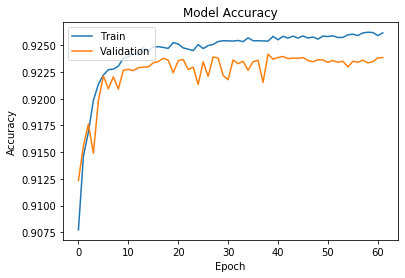

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Accuracy.png', format='png', dpi=100)

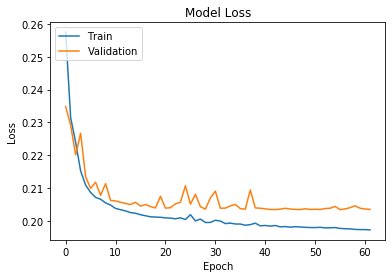

<Figure size 432x288 with 0 Axes>

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('Loss.png', format='png', dpi=100)